In [1]:
import warnings

from pprint import PrettyPrinter
import time
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA


warnings.simplefilter(action="ignore", category=FutureWarning)

In [15]:
def wrangle(filepath):
    df = pd.read_csv(filepath, index_col=[1])
    
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize('UTC').tz_convert('Africa/Nairobi')
    
    df = df[df["P2"] < 200]
    
    y = df['P2'].resample('1H').mean().fillna(method='ffill')
    
    
    return y

In [19]:
y =wrangle('lagos_air_quality.csv')

In [20]:
df.head()

timestamp
2018-10-01 03:00:00+03:00    0.010000
2018-10-01 04:00:00+03:00    0.010000
2018-10-01 05:00:00+03:00    0.010000
2018-10-01 06:00:00+03:00    0.010000
2018-10-01 07:00:00+03:00    3.147692
Freq: H, Name: P2, dtype: float64

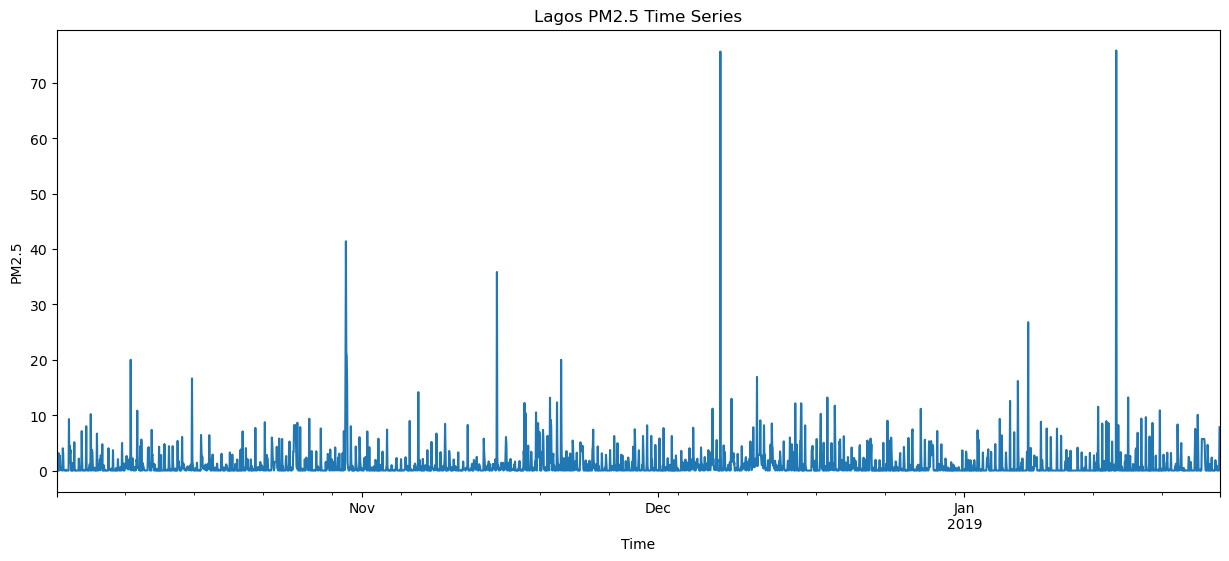

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(xlabel='Time', ylabel='PM2.5', title='Lagos PM2.5 Time Series' ,ax=ax);

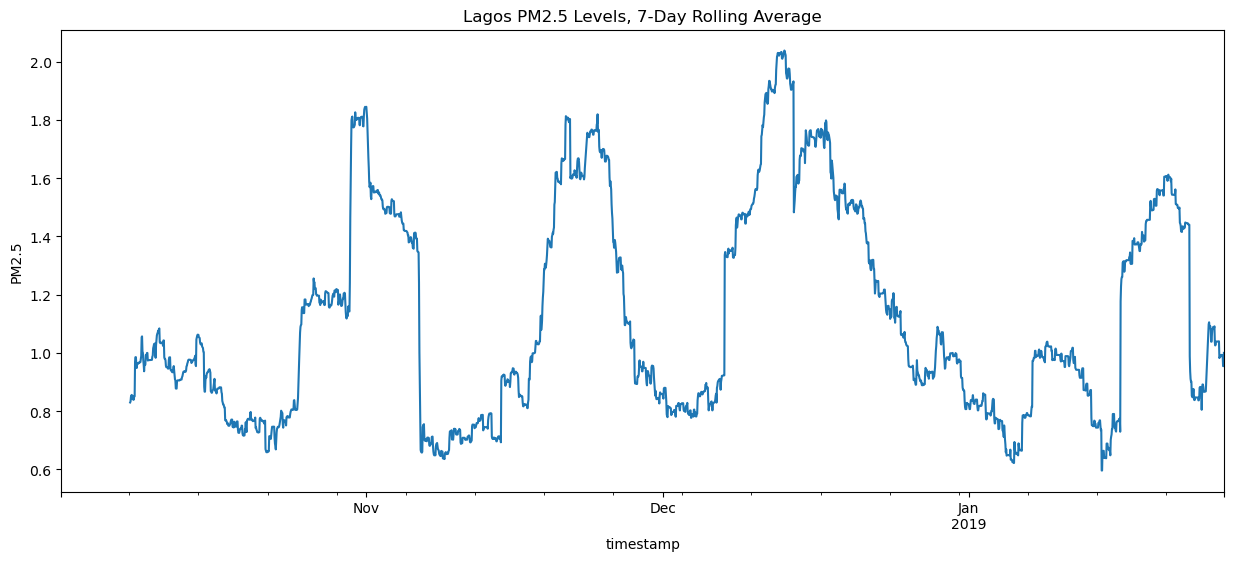

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(168).mean().plot(ax=ax, ylabel='PM2.5', title="Lagos PM2.5 Levels, 7-Day Rolling Average");

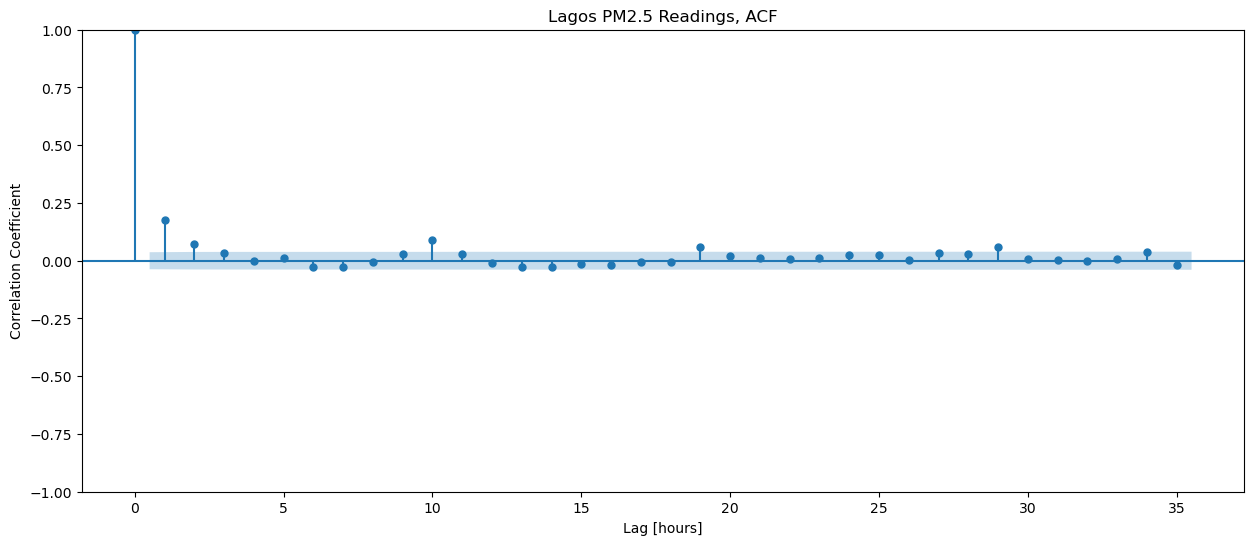

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Lagos PM2.5 Readings, ACF");

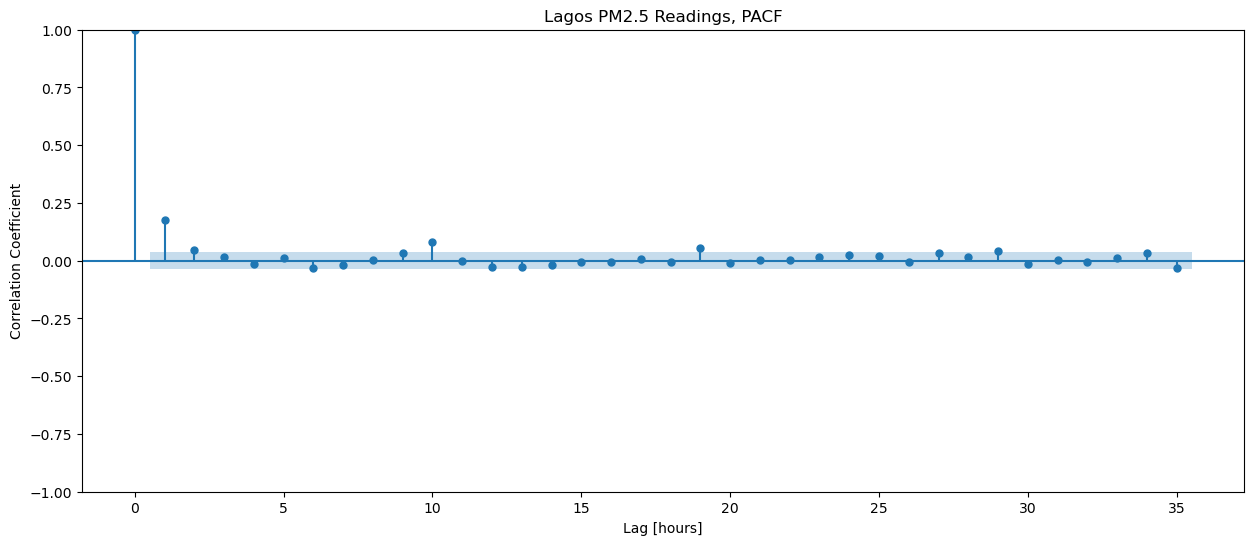

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Lagos PM2.5 Readings, PACF");

In [27]:
cutoff_test = int(len(y) * 0.90)
y_train = y.iloc[: cutoff_test]
y_test = y.iloc[cutoff_test :]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (2543,)
y_test shape: (283,)


In [28]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 1.0902885996245366
Baseline MAE: 1.386293428527685


In [29]:
p_params = range(1, 19)
maes = []
for p in p_params:
    model = AutoReg(y_train, lags=p, old_names=False).fit()
    y_pred = model.predict().dropna()
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)
    maes.append(mae)
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

1    1.319516
2    1.318413
3    1.318510
4    1.318962
5    1.317746
Name: mae, dtype: float64

In [45]:
best_p = mae_series.idxmin()
best_model = AutoReg(y_train, lags=best_p).fit()

In [46]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2018-10-01 19:00:00+03:00   -1.548549
2018-10-01 20:00:00+03:00   -1.221655
2018-10-01 21:00:00+03:00   -0.824297
2018-10-01 22:00:00+03:00   -0.674164
2018-10-01 23:00:00+03:00   -0.574815
Freq: H, Name: residuals, dtype: float64

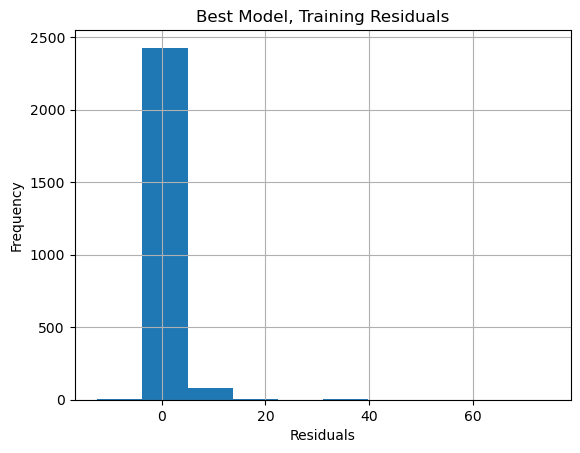

In [47]:
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.title("Best Model, Training Residuals");

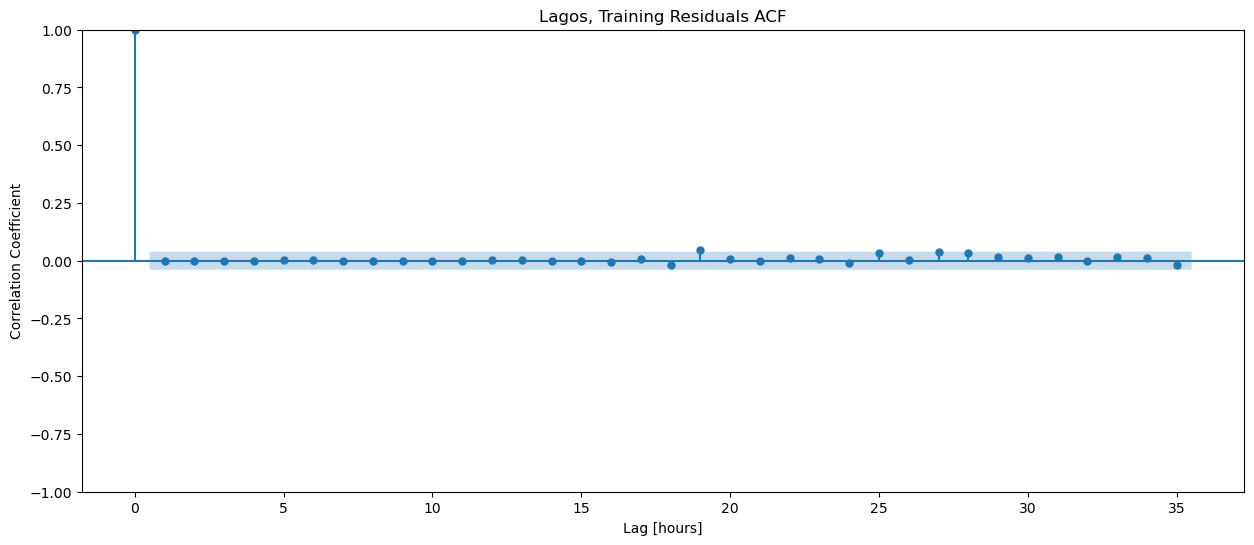

In [48]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Lagos, Training Residuals ACF");

In [49]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2019-01-15 02:00:00+03:00    0.804858
2019-01-15 03:00:00+03:00    0.475164
2019-01-15 04:00:00+03:00    0.775402
2019-01-15 05:00:00+03:00    0.939307
2019-01-15 06:00:00+03:00    0.735054
Freq: H, Name: prediction, dtype: float64

In [50]:
df_pred_test = pd.DataFrame({'y_test': y_test, 'y_pred_wfv': y_pred_wfv})
fig = px.line(df_pred_test,labels={'values': 'PM2.5'})
fig.update_layout(
    title="Lagos, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)